# Hyperparameter Tuning and Dimension Reduction

In [227]:
# data processing
import pandas as pd
import numpy as np

# data splitting
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier

# model evaluation
from sklearn.metrics import *



Read the data

In [228]:
# read the data
w = 'wine'
wine = pd.read_csv('data/' + w + '.csv')

In [229]:
wine

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_label,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,1.0,0.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,0.0,1.0
5316,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,0.0,1.0
5317,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,0.0,1.0
5318,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,0.0,1.0


Split data

In [230]:
X = wine.drop(['quality_label'], axis=1) # features
y = wine['quality_label']  # target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Evaluation function

In [231]:
def evaluate_model(model, X_test, y_test):
# just runs a model and outputs it's evaluation metrics

    try: # if there is no errors

        # make predictions on the test set
        y_pred = model.predict(X_test)

        # evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        kappa = cohen_kappa_score(y_pred, y_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred, zero_division=0)
        
    except: # if there are errors, return 0 for evaluation
        accuracy = 0
        precision = 0
        recall = 0
        f1 = 0
        kappa = 0
        conf_matrix = 0
        classification_rep = 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1' : f1,
        'kappa': kappa
        }, conf_matrix, classification_rep



Get a baseline

In [232]:
rf = RandomForestClassifier()

# fit model
rf.fit(X_train, y_train.ravel())

RandomForestClassifier()

In [233]:
eval_dict, conf_matrix, classification_rep  = evaluate_model(rf, X_test, y_test)

eval_metrics = []

# save evaluation metrics for all models
eval_metrics.append({
    'model' : 'baseline',
    'accuracy': eval_dict['accuracy'],
    'precision': eval_dict['precision'],
    'recall': eval_dict['recall'],
    'f1': eval_dict['f1'],
    'kappa': eval_dict['kappa']
    })

print(classification_rep)
print(conf_matrix)
pd.DataFrame.from_dict(eval_metrics)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       368
           1       0.79      0.82      0.80       667
           2       1.00      0.03      0.07        29

    accuracy                           0.75      1064
   macro avg       0.82      0.51      0.51      1064
weighted avg       0.75      0.75      0.74      1064

[[246 122   0]
 [120 547   0]
 [  1  27   1]]


,model,accuracy,precision,recall,f1,kappa
0,baseline,0.746241,0.751766,0.746241,0.736494,0.46079


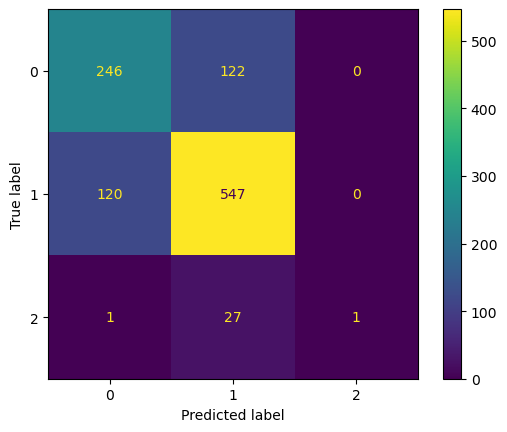

In [234]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

Set the hyperparameters to be optimized

In [235]:
param_dist = {'n_estimators': np.arange(10,500,10),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2', None],
              'class_weight': ['balanced', 'balanced_subsample'],
              'max_depth': range(1,20)}

Train RandomSearchCV (it looks for the optimal hyperparameters)

In [236]:
# create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=5, random_state=0)

# fit the object to the data
random_search.fit(X_train, y_train)

KeyboardInterrupt: 

Get the best hyperparameter combination

In [ ]:
print("The best parameters are %s with a score of %0.4f"
      % (random_search.best_params_, random_search.best_score_))

The best parameters are {'n_estimators': 460, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample'} with a score of 0.5452


In [ ]:
# create a variable for the best model
best_rf = random_search.best_estimator_

In [ ]:
eval_dict, conf_matrix, classification_rep  = evaluate_model(best_rf, X_test, y_test)

# save evaluation metrics for all models
eval_metrics.append({
    'model' : 'parameter tuning',
    'accuracy': eval_dict['accuracy'],
    'precision': eval_dict['precision'],
    'recall': eval_dict['recall'],
    'f1': eval_dict['f1'],
    'kappa': eval_dict['kappa']
    })

print(classification_rep)
print(conf_matrix)
pd.DataFrame.from_dict(eval_metrics)

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       278
           1       0.79      0.74      0.76       492
           2       0.08      0.09      0.09        23

    accuracy                           0.71       793
   macro avg       0.51      0.51      0.51       793
weighted avg       0.72      0.71      0.71       793

[[200  78   0]
 [108 362  22]
 [  0  21   2]]


,model,accuracy,precision,recall,f1,kappa
0,baseline,0.740227,0.716368,0.740227,0.727547,0.447000
1,parameter tuning,0.711223,0.717250,0.711223,0.713107,0.425073


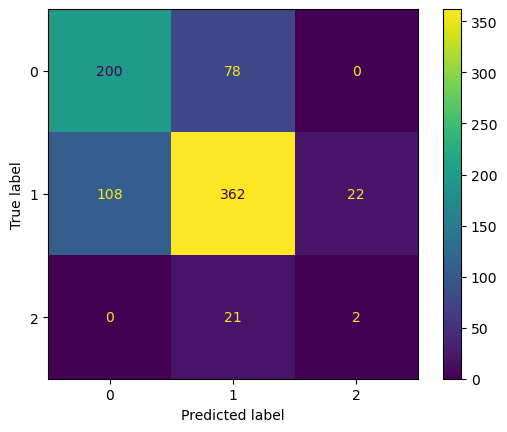

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

Get feature importance

<Axes: >

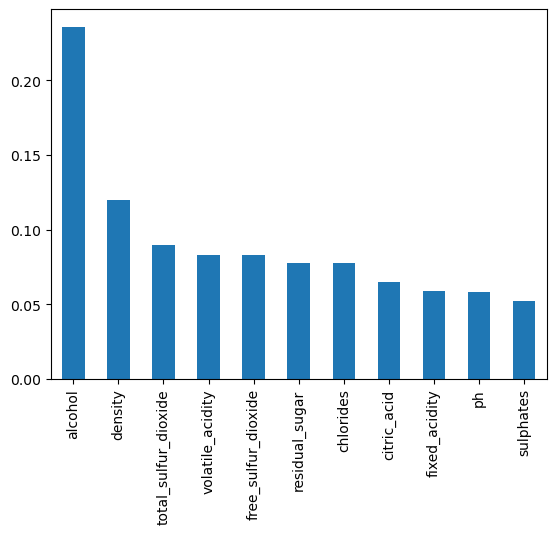

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [ ]:
X_train_feature = X_train.copy()
X_test_feature = X_test.copy()

In [ ]:
for feature in feature_importances.sort_values().index[:-2]:
    print(feature)

    # remove the feature
    X_train_feature = X_train_feature.drop(feature, axis=1)
    X_test_feature = X_test_feature.drop(feature, axis=1)

    # train new model without the feature
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train_feature, y_train.ravel())

    # get evaluation
    eval_dict, conf_matrix, classification_rep  = evaluate_model(rf, X_test_feature, y_test)

    # save evaluation metrics for all models
    eval_metrics.append({
        'model' : feature,
        'accuracy': eval_dict['accuracy'],
        'precision': eval_dict['precision'],
        'recall': eval_dict['recall'],
        'f1': eval_dict['f1'],
        'kappa': eval_dict['kappa']
        })

    print(classification_rep)
    print(conf_matrix)

pd.DataFrame.from_dict(eval_metrics)
        

sulphates
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       278
           1       0.77      0.81      0.79       492
           2       0.00      0.00      0.00        23

    accuracy                           0.73       793
   macro avg       0.48      0.49      0.48       793
weighted avg       0.71      0.73      0.72       793

[[181  97   0]
 [ 91 400   1]
 [  0  23   0]]
ph
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       278
           1       0.77      0.82      0.79       492
           2       0.00      0.00      0.00        23

    accuracy                           0.74       793
   macro avg       0.48      0.49      0.48       793
weighted avg       0.71      0.74      0.72       793

[[178  99   1]
 [ 84 405   3]
 [  0  23   0]]
fixed_acidity
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       278
          

,model,accuracy,precision,recall,f1,kappa
0,baseline,0.740227,0.716368,0.740227,0.727547,0.447000
1,parameter tuning,0.711223,0.717250,0.711223,0.713107,0.425073
2,sulphates,0.732661,0.710535,0.732661,0.721195,0.434657
3,ph,0.735183,0.714972,0.735183,0.724292,0.438607
4,fixed_acidity,0.737705,0.715072,0.737705,0.724889,0.438532
5,citric_acid,0.732661,0.709444,0.732661,0.720045,0.429732
6,chlorides,0.717528,0.695962,0.717528,0.705556,0.397621
7,residual_sugar,0.706179,0.683091,0.706179,0.692952,0.369671
8,free_sulfur_dioxide,0.692308,0.675947,0.692308,0.680883,0.341631
9,volatile_acidity,0.651955,0.638498,0.651955,0.636473,0.243961


In [ ]:
X_train_feature = X_train.copy()
X_test_feature = X_test.copy()

In [ ]:
random_search.best_params_

{'n_estimators': 460,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'log_loss',
 'class_weight': 'balanced_subsample'}

In [ ]:
for feature in feature_importances.sort_values().index[:-2]:
    print(feature)

    # remove the feature
    X_train_feature = X_train_feature.drop(feature, axis=1)
    X_test_feature = X_test_feature.drop(feature, axis=1)

    # train new model without the feature
    rf = RandomForestClassifier(
        class_weight=random_search.best_params_['class_weight'],
        criterion=random_search.best_params_['criterion'],
        max_depth=random_search.best_params_['max_depth'],
        max_features=random_search.best_params_['max_features'],
        n_estimators=random_search.best_params_['n_estimators'],
        random_state=0
    )
    rf.fit(X_train_feature, y_train.ravel())

    # get evaluation
    eval_dict, conf_matrix, classification_rep  = evaluate_model(rf, X_test_feature, y_test)

    # save evaluation metrics for all models
    eval_metrics.append({
        'model' : feature + '_parameter',
        'accuracy': eval_dict['accuracy'],
        'precision': eval_dict['precision'],
        'recall': eval_dict['recall'],
        'f1': eval_dict['f1'],
        'kappa': eval_dict['kappa']
        })

    print(classification_rep)
    print(conf_matrix)

pd.DataFrame.from_dict(eval_metrics)
        

sulphates
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       278
           1       0.78      0.74      0.76       492
           2       0.05      0.04      0.04        23

    accuracy                           0.71       793
   macro avg       0.49      0.50      0.49       793
weighted avg       0.71      0.71      0.71       793

[[197  81   0]
 [106 365  21]
 [  0  22   1]]
ph
              precision    recall  f1-score   support

           0       0.65      0.70      0.67       278
           1       0.78      0.73      0.75       492
           2       0.07      0.09      0.08        23

    accuracy                           0.70       793
   macro avg       0.50      0.51      0.50       793
weighted avg       0.71      0.70      0.70       793

[[195  83   0]
 [106 359  27]
 [  0  21   2]]
fixed_acidity
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       278
          

,model,accuracy,precision,recall,f1,kappa
0,baseline,0.740227,0.716368,0.740227,0.727547,0.447000
1,parameter tuning,0.711223,0.717250,0.711223,0.713107,0.425073
2,sulphates,0.732661,0.710535,0.732661,0.721195,0.434657
3,ph,0.735183,0.714972,0.735183,0.724292,0.438607
4,fixed_acidity,0.737705,0.715072,0.737705,0.724889,0.438532
5,citric_acid,0.732661,0.709444,0.732661,0.720045,0.429732
6,chlorides,0.717528,0.695962,0.717528,0.705556,0.397621
7,residual_sugar,0.706179,0.683091,0.706179,0.692952,0.369671
8,free_sulfur_dioxide,0.692308,0.675947,0.692308,0.680883,0.341631
9,volatile_acidity,0.651955,0.638498,0.651955,0.636473,0.243961
